In [1]:
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns, nltk, re
from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split

%matplotlib inline

nltk.download('punkt')
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to /Users/jkovach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/jkovach/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

Supervised NLP doesn't capture semantics (meaning) of language
Unsupervised learns by identifying recurring patterns within corpus
Dataset would need to have sufficient scope
Latent semantic analysis

Convert sentences to vectors:
1. reduce words to lemmas, remove stop words and those that only occur once
2. Term-document matrix consists of x(terms) and y(document, usually sentences, chunks of text)
3. apply weights so that less frequent words have higher weights (still exclude words that only occur once)

Quantify documents: Collection vs. Document Frequencies
1. Document frequency - how many documents(sentences) a word occurs in
2. Collection frequency - total occurances over all sentences

Penalizing indiscriminate words: IDF
1. Inverse document frequency - weight applied to less frequent words
2. log2 of number of docs divded by document frequency

Term frequency weights
1. creating unique weights for each sentence
2. term frequency times idf for the term

tf idf converts human readable language into computer useable numeric data. Possible decision points include:
1. stop words to include or exclude
2. phrase usage ('monty', 'python' versus 'monty python')
3. Threshold for infrequent words
4. number of terms to keep as features

Space vector model
1. vector representation of text used to compute similarity between known sentences and new inputs
2. new sentences are transformed to vectors and placed in the vector space, angles calculated between existing and new vectors
3. calculation is typically the cosine of the angle between vectors, 0deg=1 would be best case outcome
4. weaknesses: synonyms, polysemy

Latent Semantic Analysis:
1. applying PCA to a tf-idf td matrix, resulting in clusters of terms that represent a topic
2. each document will get a score, higher scores are more relevant, documents may score for multiple topics
3. corpus is too large to manually annotate


In [2]:
# Read the data as paragraphs
emma = gutenberg.paras('austen-emma.txt')

# Processing
emma_paras = []
for paragraph in emma:
    para=paragraph[0]
    
    # Remove double dash
    para=[re.sub(r'--', '', word) for word in para]
    
    # Format to string and add to list
    emma_paras.append(' '.join(para))

print(emma_paras[:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [37]:
# Tf-idf with Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than half the paragraphs
                             min_df=2, #only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #converts all words to lowercase
                             use_idf=True, #use idf as weights
                             norm=u'l1', #correction factor for document length (L1, L2, or max)
                             smooth_idf=True #Adds 1 to all doc frequencies, prevents divide by zero errors
                            )

# Apply vectorizer and split to training/test sets
emma_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_tfidf.get_shape()[1])
X_train_tfidf, X_test_tfidf = train_test_split(emma_tfidf, test_size=0.4, random_state=0)

# Reshapes output into human readable format
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Get number of paragraphs
n = X_train_tfidf_csr.shape[0]

# Create one dictionary per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# List feature words and tfidf scores for each paragraph
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
print('Original Sentence:', X_train[5])
print('TF_IDF Vector:', tfidf_bypara[5])

Number of features: 1948
Original Sentence: A very few minutes more , however , completed the present trial .
TF_IDF Vector: {'minutes': 0.5040029961941199, 'present': 0.49599700380588013}


In [38]:
# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# SVD data reducer, reducing to 130 features
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data then project
X_train_lsa = lsa.fit_transform(X_train_tfidf)

exp_var = svd.explained_variance_ratio_
total_variance = exp_var.sum()
print("Variance captured by new components: {}".format(total_variance*100))

# See what paragraphs the model considers similar
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Variance captured by new components: 63.680171849818414
Component 0
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !     0.999928
" Oh !"    0.999928
" Oh !     0.999928
Name: 0, dtype: float64
Component 1
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
" Ah !    0.999988
Name: 1, dtype: float64
Component 2
CHAPTER V      0.997111
CHAPTER V      0.997111
CHAPTER I      0.997111
CHAPTER X      0.997111
CHAPTER I      0.997111
CHAPTER X      0.997111
CHAPTER I      0.997111
CHAPTER V      0.997111
CHAPTER X      0.997111
CHAPTER XII    0.993513
Name: 2, dtype: float64
Component 3
" From something that he said , my dear Emma , I rather imagine "                                                                                                         0.823055
" Emma , my dea

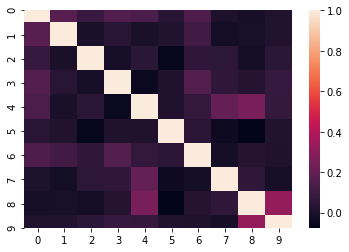

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [9]:
# Sentence Similarity
# Compute similarity between documents with LSA
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

# Creating a key for the plot
print('Key:')
for i in range(10):
    print(i, sim_matrix.index[i])

In [10]:
# Drill #0: implement with test data
X_test_tfidf_csr = X_test_tfidf.tocsr()
nt = X_test_tfidf_csr.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]
    
X_test_lsa = lsa.fit_transform(X_test_tfidf)

exp_var = svd.explained_variance_ratio_
total_variance = exp_var.sum()
print("Variance captured by new components: {}".format(total_variance*100))

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Variance captured by new components: 49.37289827084208
Component 0
" Oh !       0.999922
" Oh !       0.999922
" Oh !       0.999922
" Oh !       0.999922
" Oh !       0.999922
" Oh !       0.999922
" Oh no !    0.999922
" Oh !       0.999922
" Oh !       0.999922
" Oh !       0.999922
Name: 0, dtype: float64
Component 1
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.614806
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                             